In [1]:
from os import getcwd
from os.path import join, abspath

from copy import deepcopy
from joblib import Parallel, delayed, parallel_backend
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from tqdm import tqdm

from src.models.estimator import RFClassifier, relu
from src.models.weights import V1_weights, classical_weights
from src.data.load_dataset import load_mnist

In [2]:
data_dir = abspath(join(getcwd(), '../../'))

In [3]:
# load dataset
train_loader, val_loader, test_loader = load_mnist()
train, test = train_loader.dataset.dataset, test_loader.dataset
train, train_labels = train.data.numpy(), train.targets.numpy()
X_test, y_test = test.data.numpy(), test.targets.numpy()

X_train, X_val, y_train, y_val = train_test_split(train, train_labels, train_size=0.999, stratify=train_labels)


# training params
num_neurons = sorted(set(np.logspace(0, 3.5, 50).astype('int')))
num_trials = 5
nonlinearity = relu
bias = 0
scale = 1
clf = LinearSVC(tol=1e-4, max_iter=1000)
n_jobs=3

# V1 params
compatible = {'s': 5, 'f':2}
incompatible = {'s': 10, 'f':18}

#### V1 RFNet with optimal parameters $s=5$ and $f=2$

In [ ]:
s, f = compatible['s'], compatible['f']
kwargs = {'size':s, 'spatial_freq':f, 'center':None, 'scale':scale}
test_V1 = {'hidden_size': [], 'mean': [], 'std_err': []}

for n in tqdm(num_neurons):
    classifiers = [RFClassifier(n, V1_weights, bias, nonlinearity, deepcopy(clf), kwargs) for i in range(num_trials)]
    with parallel_backend('threading', n_jobs=n_jobs):
        Parallel()(delayed(RFclf.fit)(X_train, y_train) for RFclf in classifiers)
        test_accuracy = [RFclf.score(X_test, y_test) for RFclf in classifiers]
    
    test_V1['mean'].append(np.mean(test_accuracy))
    test_V1['std_err'].append(np.std(test_accuracy) / np.sqrt(num_trials))
    test_V1['hidden_size'].append(n)

#### Classical weights

In [ ]:
kwargs = {'scale':scale}
test_classical = {'hidden_size': [], 'mean': [], 'std_err': []}

for n in tqdm(num_neurons):
    classifiers = [RFClassifier(n, classical_weights, bias, nonlinearity, deepcopy(clf), kwargs) for i in range(num_trials)]
    with parallel_backend('threading', n_jobs=n_jobs):
        Parallel()(delayed(RFclf.fit)(X_train, y_train) for RFclf in classifiers)
        test_accuracy = [RFclf.score(X_test, y_test) for RFclf in classifiers]
        
    test_classical['mean'].append(np.mean(test_accuracy))
    test_classical['std_err'].append(np.std(test_accuracy) / np.sqrt(num_trials))
    test_classical['hidden_size'].append(n)

#### Incompatible RFNet with parameters $s=10$ and $f=18$

In [ ]:
s, f = incompatible['s'], incompatible['f']
kwargs = {'size':s, 'spatial_freq':f, 'center':None, 'scale':scale}
test_incompatible = {'hidden_size': [], 'mean': [], 'std_err': []}

for n in tqdm(num_neurons):
    classifiers = [RFClassifier(n, V1_weights, bias, nonlinearity, deepcopy(clf), kwargs) for i in range(num_trials)]
    with parallel_backend('threading', n_jobs=n_jobs):
        Parallel()(delayed(RFclf.fit)(X_train, y_train) for RFclf in classifiers)
        test_accuracy = [RFclf.score(X_test, y_test) for RFclf in classifiers]
    
    test_incompatible['mean'].append(np.mean(test_accuracy))
    test_incompatible['std_err'].append(np.std(test_accuracy) / np.sqrt(num_trials))
    test_incompatible['hidden_size'].append(n)

In [ ]:
# save
s, f = compatible['s'], compatible['f']
test = {'V1': test_V1, 'classical': test_classical, 'incompatible': test_incompatible}
data_dir = abspath(join(getcwd(), '../../'))
with open(data_dir + '/models/results/mnist_clf/mnist_clf_s=%0.2f_f=%0.2f_estimator.pickle' % (s, f), 'wb') as handle:
    pickle.dump(test, handle, protocol=pickle.HIGHEST_PROTOCOL) 

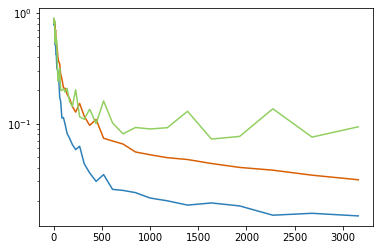

In [4]:
# plot
compatible = {'s': 5, 'f':2}
s, f = compatible['s'], compatible['f']
with open(data_dir + '/models/results/mnist_clf/mnist_clf_s=%0.2f_f=%0.2f_estimator.pickle' % (s, f), 'rb') as file:
    results = pickle.load(file) 

fig = plt.figure()
plt.semilogy(results['V1']['hidden_size'], 1 - np.array(results['V1']['mean']), c='#2c7fb8')
plt.semilogy(results['classical']['hidden_size'], 1 - np.array(results['classical']['mean']), c='#d95f02')
plt.semilogy(results['incompatible']['hidden_size'], 1 - np.array(results['incompatible']['mean']), c='#91cf60')
# plt.xlim([0, 1000])

In [6]:
list(zip(results['V1']['hidden_size'], 1 - np.array(results['V1']['mean'])))

[(1, 0.8688),
 (2, 0.84082),
 (3, 0.86712),
 (4, 0.82036),
 (5, 0.78034),
 (6, 0.8399000000000001),
 (7, 0.7651),
 (8, 0.8226800000000001),
 (10, 0.71846),
 (11, 0.72182),
 (13, 0.68196),
 (16, 0.50864),
 (19, 0.5729200000000001),
 (22, 0.42276),
 (26, 0.4226),
 (31, 0.32442000000000004),
 (37, 0.30577999999999994),
 (43, 0.29896),
 (51, 0.2589),
 (61, 0.17425999999999997),
 (71, 0.15900000000000003),
 (84, 0.11237999999999992),
 (100, 0.1132200000000001),
 (117, 0.09860000000000002),
 (138, 0.08141999999999994),
 (163, 0.07395999999999991),
 (193, 0.06454000000000004),
 (227, 0.05822000000000005),
 (268, 0.06244000000000016),
 (316, 0.043340000000000045),
 (372, 0.03590000000000004),
 (439, 0.030080000000000107),
 (517, 0.034619999999999984),
 (610, 0.025460000000000038),
 (719, 0.024920000000000053),
 (848, 0.023799999999999932),
 (1000, 0.021260000000000057),
 (1178, 0.020079999999999876),
 (1389, 0.018360000000000043),
 (1637, 0.019199999999999995),
 (1930, 0.018039999999999834),
 

In [ ]:
with open(data_dir + '/models/results/mnist_clf/mnist_param_study_estimator.pickle', 'rb') as file:
    results = pickle.load(file)
    
grid = np.arange(1, 20, 1)
mean = np.mean(results['scores'], axis=1)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(mean.reshape(19, 19), cmap='RdBu_r')
plt.xticks(grid - 1)
plt.yticks(grid - 1)
ax.set_xticklabels(grid)
ax.set_yticklabels(grid)
# plt.imshow(results['scores'])
plt.clim(0.7, 1)
plt.colorbar()

# print the largest param
idx = np.argmax(mean)
print(results['size'][idx], results['spatial_freq'][idx], mean[idx])

In [ ]:
print(20)